In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
baseline_df = pd.read_csv("baseline_data.csv")
pipeline_df_no_feedback = pd.read_csv("pipeline_data.csv")
pipeline_df_full = pipeline_df_no_feedback.copy()

In [6]:
baseline_df['PassNum'] = baseline_df["Pass@k"].str.replace("Pass@","").astype(int)
pipeline_df_no_feedback["PassNum"] = pipeline_df_no_feedback["Pass@k"].str.replace("Pass@","").astype(int)
pipeline_df_full["PassNum"] = pipeline_df_no_feedback["Pass@k"].str.replace("Pass@","").astype(int)

In [7]:
pipeline_df_full["Output Used for Retry"].replace(
    {"Yes": "With Feedback", "No": "No Feedback"},
    inplace=True
)

/var/folders/lj/sxccwwrn2k7fmmggnqk78d3c0000gn/T/ipykernel_85447/2539697314.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pipeline_df_full["Output Used for Retry"].replace(


In [8]:
pipeline_df_no_feedback = pipeline_df_no_feedback[pipeline_df_no_feedback["Output Used for Retry"] == "No"]
pipeline_df_no_feedback = pipeline_df_no_feedback.reset_index(drop=True)
pipeline_df_no_feedback = pipeline_df_no_feedback.drop(columns=['Output Used for Retry'])

In [9]:
print(baseline_df)

            LLM    Dataset  Pass@k  Success  Partial Success  Failure  \
0   GPT-4o-mini       MBPP  Pass@1     47.8             48.6      3.6   
1   GPT-4o-mini       MBPP  Pass@2     47.9             49.5      2.6   
2   GPT-4o-mini       MBPP  Pass@3     48.0             50.0      2.0   
3   DeepSeek-v3       MBPP  Pass@1     70.2             22.2      7.6   
4   DeepSeek-v3       MBPP  Pass@2     74.2             23.9      1.8   
5   DeepSeek-v3       MBPP  Pass@3     74.5             23.9      1.5   
6   GPT-4o-mini  HumanEval  Pass@1     47.0             51.2      1.8   
7   GPT-4o-mini  HumanEval  Pass@2     47.0             51.8      1.2   
8   GPT-4o-mini  HumanEval  Pass@3     47.0             52.4      0.6   
9   DeepSeek-v3  HumanEval  Pass@1     71.3             27.4      1.2   
10  DeepSeek-v3  HumanEval  Pass@2     71.3             28.0      0.6   
11  DeepSeek-v3  HumanEval  Pass@3     71.3             28.0      0.6   

    Coverage  PassNum  
0       99.8        1  
1 

In [10]:
print(pipeline_df_no_feedback)

            LLM    Dataset  Pass@k  Retry-0  Retry-1  Retry-2  Retry-3  \
0   GPT-4o-mini       MBPP  Pass@1     45.8     12.4      2.8      1.2   
1   GPT-4o-mini       MBPP  Pass@2     45.5     12.3      2.9      1.1   
2   GPT-4o-mini       MBPP  Pass@3     45.5     12.2      3.0      1.1   
3   DeepSeek-v3       MBPP  Pass@1     70.1      9.6      2.3      1.1   
4   DeepSeek-v3       MBPP  Pass@2     70.2      9.5      2.3      1.0   
5   DeepSeek-v3       MBPP  Pass@3     70.1      9.6      2.3      1.0   
6   GPT-4o-mini  HumanEval  Pass@1     47.5     17.7      2.5      0.0   
7   GPT-4o-mini  HumanEval  Pass@2     46.9     17.5      2.5      0.0   
8   GPT-4o-mini  HumanEval  Pass@3     46.9     17.5      2.5      0.0   
9   DeepSeek-v3  HumanEval  Pass@1     60.9     16.8      3.1      1.9   
10  DeepSeek-v3  HumanEval  Pass@2     60.7     16.6      3.1      1.8   
11  DeepSeek-v3  HumanEval  Pass@3     60.7     16.6      3.1      1.8   

    Retry-4  Retry-5  Success  Failur

In [11]:
pipeline_df_no_feedback['Condition'] = (
    pipeline_df_no_feedback['LLM'] + ' / ' +
    pipeline_df_no_feedback['Dataset'] + ' / Pipeline'
)
baseline_df['Condition'] = baseline_df['LLM'] + ' / ' + baseline_df['Dataset'] + ' / Baseline'

#### Success Rate over Pass@k

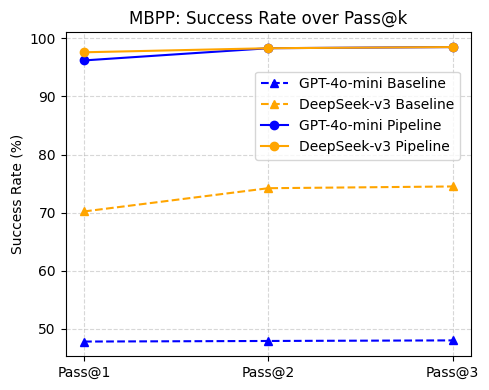

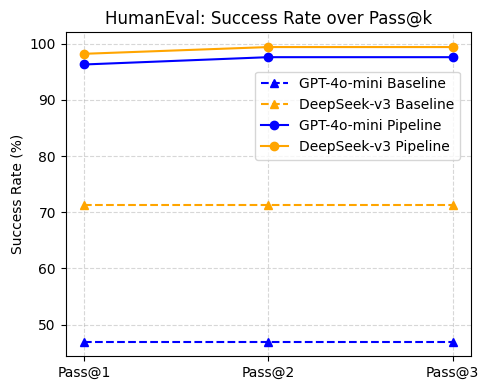

In [12]:
line_styles = {
    'Baseline': ('--', None),
    'Pipeline': ('-', None)
}
color_map = {
    'GPT-4o-mini': 'blue',
    'DeepSeek-v3': 'orange'
}

for dataset in ['MBPP', 'HumanEval']:
    plt.figure(figsize=(5, 4))
    for llm in baseline_df['LLM'].unique():
        df_base = baseline_df[(baseline_df['LLM'] == llm) & (baseline_df['Dataset'] == dataset)]
        if df_base.empty:
            continue
        linestyle, _ = line_styles['Baseline']
        plt.plot(
            df_base['PassNum'],
            df_base['Success'],
            linestyle=linestyle,
            color=color_map[llm],
            marker='^',
            label=f"{llm} Baseline"
        )

    for llm in pipeline_df_no_feedback['LLM'].unique():
        df_pipe = pipeline_df_no_feedback[
            (pipeline_df_no_feedback['LLM'] == llm) &
            (pipeline_df_no_feedback['Dataset'] == dataset)
        ]
        if df_pipe.empty:
            continue
        linestyle, _ = line_styles['Pipeline']
        
        plt.plot(
            df_pipe['PassNum'],
            df_pipe['Success'],
            linestyle=linestyle,
            color=color_map[llm],
            marker='o',
            label=f"{llm} Pipeline"
        )    
    plt.xticks([1, 2, 3], ['Pass@1', 'Pass@2', 'Pass@3'])
    plt.ylabel('Success Rate (%)')
    plt.title(f'{dataset}: Success Rate over Pass@k')
    plt.legend(bbox_to_anchor=(0.45,0.90), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

#### Retry-Depth Distribution (Pass@3)

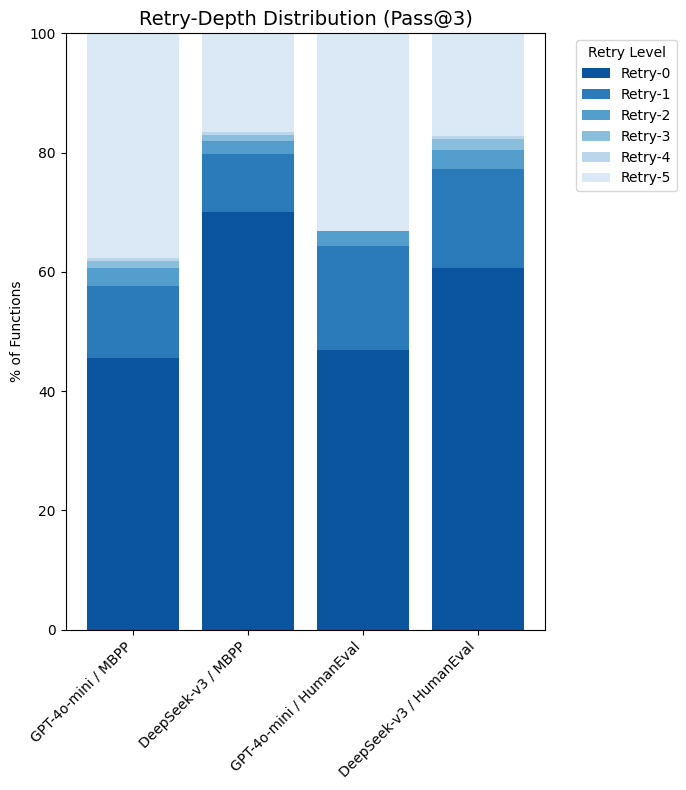

In [13]:
retry_df = pipeline_df_no_feedback[pipeline_df_no_feedback['Pass@k']=='Pass@3'].copy()
retry_df['Label'] = retry_df['LLM'] + ' / ' + retry_df['Dataset'] 
retry_cols = ['Retry-0','Retry-1','Retry-2','Retry-3','Retry-4','Retry-5']
labels = retry_df['Label'].tolist()
data_matrix = retry_df[retry_cols].values

fig, ax = plt.subplots(figsize=(7, 8))
bottom = np.zeros(len(labels))
colors = sns.color_palette("Blues", n_colors=6)[::-1]

for idx, col in enumerate(retry_cols):
    ax.bar(
        labels,
        retry_df[col],
        bottom=bottom,
        color=colors[idx],
        label=col
    )
    bottom += retry_df[col].to_numpy()

ax.set_title('Retry-Depth Distribution (Pass@3)', fontsize=14)
ax.set_ylabel('% of Functions')
ax.set_ylim(0, 100)
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend(title='Retry Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Baseline vs Pipeline Coverage for Sucecss(Pass@3)

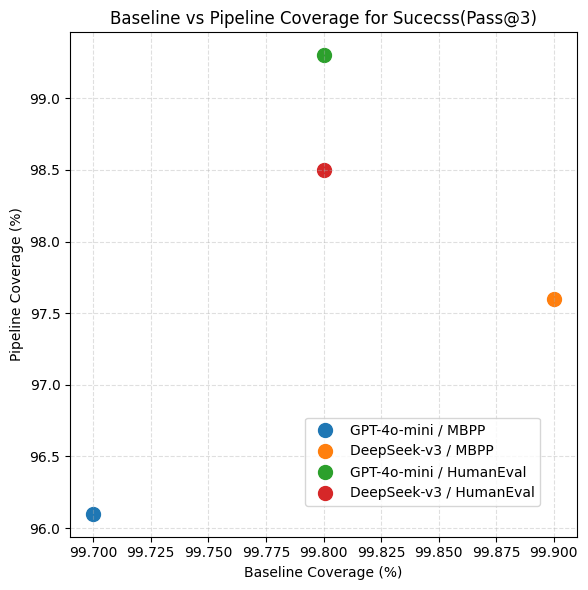

In [14]:
base_p3 = baseline_df[baseline_df['Pass@k']=='Pass@3'][['LLM','Dataset','Coverage']].copy()
base_p3 = base_p3.rename(columns={'Coverage':'Baseline_Cov'})
pipe_p3 = pipeline_df_no_feedback[pipeline_df_no_feedback['Pass@k']=='Pass@3'][['LLM','Dataset','Coverage']].copy()
pipe_p3 = pipe_p3.rename(columns={'Coverage':'Pipeline_Cov'})
cov_scatter = pipe_p3.merge(base_p3, on=['LLM','Dataset'])
cov_scatter['Label'] = cov_scatter['LLM'] + ' / ' + cov_scatter['Dataset'] 

fig, ax = plt.subplots(figsize=(6,6))
for _, r in cov_scatter.iterrows():
    ax.scatter(
        r['Baseline_Cov'], 
        r['Pipeline_Cov'], 
        label=r['Label'], 
        s=100
    )
ax.plot(linestyle='--', color='gray', linewidth=1)
ax.set_title('Baseline vs Pipeline Coverage for Sucecss(Pass@3)')
ax.set_xlabel('Baseline Coverage (%)')
ax.set_ylabel('Pipeline Coverage (%)')
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(bbox_to_anchor=(0.45,0.25), loc='upper left')
plt.tight_layout()
plt.show()

#### Outcome Breakdown: Baseline vs Pipeline (Pass@3)

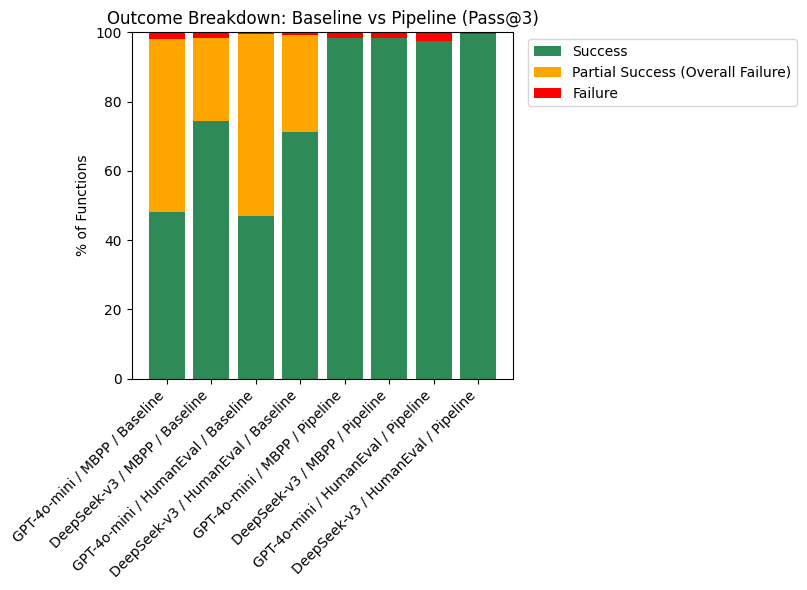

In [15]:
base_p3 = baseline_df[baseline_df['Pass@k']=='Pass@3'][['LLM','Dataset','Success','Partial Success','Failure']].copy()
base_p3['Condition'] = base_p3['LLM'] + ' / ' + base_p3['Dataset'] + ' / Baseline'
pipe_p3 = pipeline_df_no_feedback[pipeline_df_no_feedback['Pass@k']=='Pass@3'][['LLM','Dataset','Success','Failure']].copy()
pipe_p3['Partial Success'] = 0.0
pipe_p3['Condition'] = pipe_p3['LLM'] + ' / ' + pipe_p3['Dataset'] + ' / Pipeline'
columns = ['Condition','Success','Partial Success','Failure']
stack_df = pd.concat([base_p3[columns], pipe_p3[columns]], ignore_index=True)

conditions = stack_df['Condition'].tolist()
success_vals = stack_df['Success'].tolist()
partial_vals = stack_df['Partial Success'].tolist()
fail_vals = stack_df['Failure'].tolist()

fig, ax = plt.subplots(figsize=(8,6))
x = np.arange(len(conditions))
ax.bar(
    x, 
    success_vals, 
    label='Success', 
    color='seagreen'
)
ax.bar(
    x, 
    partial_vals, 
    bottom=success_vals, 
    label='Partial Success (Overall Failure)', 
    color='orange'
)
bottom2 = np.array(success_vals) + np.array(partial_vals)
ax.bar(
    x, 
    fail_vals, 
    bottom=bottom2, 
    label='Failure', 
    color='red'
)

ax.set_xticks(x)
ax.set_xticklabels(conditions, rotation=45, ha='right')
ax.set_ylabel('% of Functions')
ax.set_title('Outcome Breakdown: Baseline vs Pipeline (Pass@3)')
ax.set_ylim(0,100)
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

#### Impact of Expected Output Feedback on Retry Distribution (Pass@3)

In [16]:
def plot_retry_impact(dataset_name):
    df = pipeline_df_full[
        (pipeline_df_full['Pass@k'] == 'Pass@3') &
        (pipeline_df_full['Dataset'] == dataset_name)
    ]
    records = []
    retry_levels = ['Retry-1','Retry-2','Retry-3','Retry-4','Retry-5']
    for _, row in df.iterrows():
        llm   = row['LLM']
        output = row['Output Used for Retry']
        for level in retry_levels:
            records.append({
                'LLM': llm,
                'Output': output,
                'RetryLevel': level,
                'Pct': row[level]
            })

    temp_pd = pd.DataFrame(records)
    pivot = temp_pd.pivot_table(
        index='RetryLevel',
        columns=['LLM','Output'],
        values='Pct'
    )
 
    retry_idx = np.arange(len(retry_levels))
    n_bars = pivot.shape[1]
    total_width = 0.6
    bar_width = total_width / n_bars

    _, ax = plt.subplots(figsize=(5, 5))
    color_map = {
        'GPT-4o-mini': 'blue',
        'DeepSeek-v3': 'orange'
    }
    alpha_map = {
        'No Feedback':1.0, 
        'With Feedback':0.6
    }
    column_order = []
    for llm in ['GPT-4o-mini','DeepSeek-v3']:
        for out in ['No Feedback','With Feedback']:
            column_order.append((llm,out))

    for i, (llm,out) in enumerate(column_order):
        if (llm,out) not in pivot.columns:
            continue
        heights = pivot[(llm,out)].values
        x_positions = retry_idx + (i - (n_bars-1)/2) * bar_width
        ax.bar(
            x_positions,
            heights,
            width=bar_width,
            color=color_map[llm],
            alpha=alpha_map[out],
            label=f"{llm} / {out}",
            zorder=1
        )

    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_axisbelow(True)
    ax.set_xticks(retry_idx)
    ax.set_xticklabels(retry_levels, rotation=45, ha='right')
    ax.set_ylabel('% of Functions')
    ax.set_xlabel('Retry Level')
    ax.set_title(f'Impact of Expected Output Feedback \non Retry Distribution (Pass@3) - {dataset_name}')
    ax.set_ylim(0, 40)
    ax.legend(bbox_to_anchor=(0.50, 0.95), loc='upper center')
    plt.tight_layout()
    plt.show()

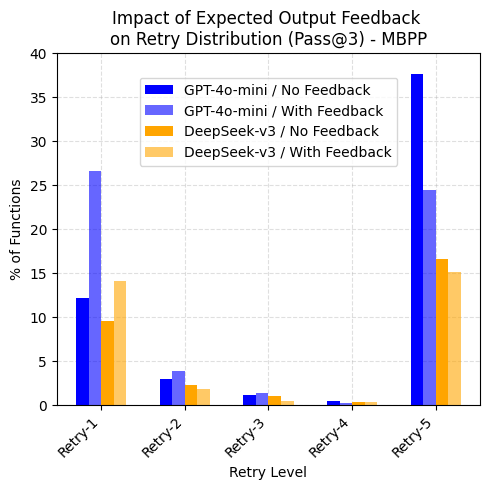

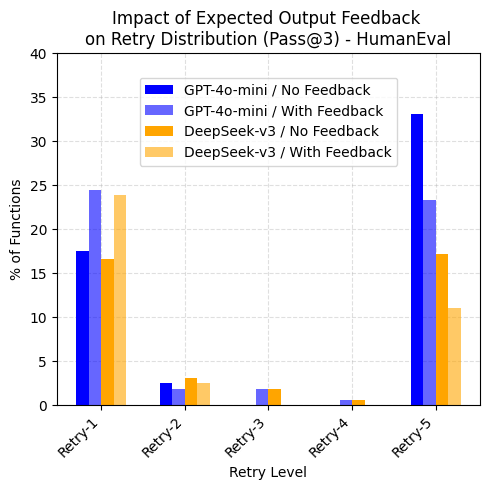

In [17]:
plot_retry_impact('MBPP')
plot_retry_impact('HumanEval')

#### Cumulative Success vs. Retry Depth (Pass@3)

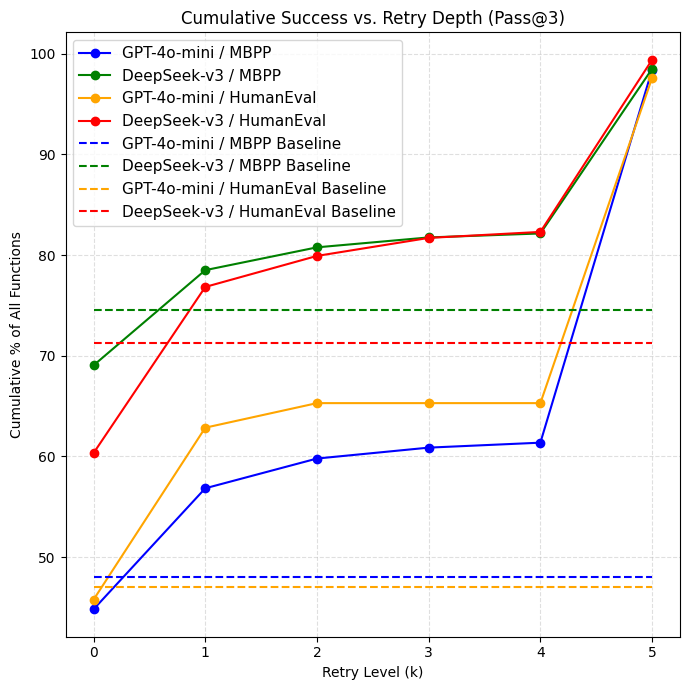

In [18]:
color_map = {
    "GPT-4o-mini/MBPP": "blue",
    "GPT-4o-mini/HumanEval": "orange",
    "DeepSeek-v3/MBPP": "green",
    "DeepSeek-v3/HumanEval": "red"
}

pipeline_pass3 = pipeline_df_no_feedback[pipeline_df_no_feedback["Pass@k"] == "Pass@3"].copy()
for k in range(6):
    retry_col = f"Retry-{k}"
    abs_col   = f"Abs-Retry-{k}"
    pipeline_pass3[abs_col] = pipeline_pass3[retry_col] * pipeline_pass3["Success"] / 100.0

pipeline_pass3["Cumulative-0"] = pipeline_pass3["Abs-Retry-0"]
for k in range(1, 6):
    pipeline_pass3[f"Cumulative-{k}"] = pipeline_pass3[f"Cumulative-{k-1}"] + pipeline_pass3[f"Abs-Retry-{k}"]

fig, ax = plt.subplots(figsize=(7, 7))
retry_levels = np.arange(6)

for _, row in pipeline_pass3.iterrows():
    llm     = row["LLM"]
    dataset = row["Dataset"]
    label = f"{llm} / {dataset}"
    key = f"{llm}/{dataset}"
    color = color_map[key]
    y = [row[f"Cumulative-{k}"] for k in retry_levels]
    ax.plot(
        retry_levels,
        y,
        marker="o",
        color=color,
        linestyle="solid",
        label=label
    )

baseline_pass3 = baseline_df[baseline_df["Pass@k"] == "Pass@3"]
for _, base_row in baseline_pass3.iterrows():
    llm     = base_row["LLM"]
    dataset = base_row["Dataset"]
    success_pct = base_row["Success"]
    key = f"{llm}/{dataset}"
    color = color_map[key]
    baseline_label = f"{llm} / {dataset} Baseline"
    ax.hlines(
        y=success_pct,
        xmin=0,
        xmax=5,
        colors=color,
        linestyles="--",
        label=baseline_label
    )

ax.set_xticks(retry_levels)
ax.set_xticklabels([str(k) for k in retry_levels])
ax.set_xlabel("Retry Level (k)")
ax.set_ylabel("Cumulative % of All Functions")
ax.set_title("Cumulative Success vs. Retry Depth (Pass@3)")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend(bbox_to_anchor=(0.00, 1), loc="upper left", fontsize=11)
plt.tight_layout()
plt.show()

#### Avg Retry vs. Success (Pass@3)

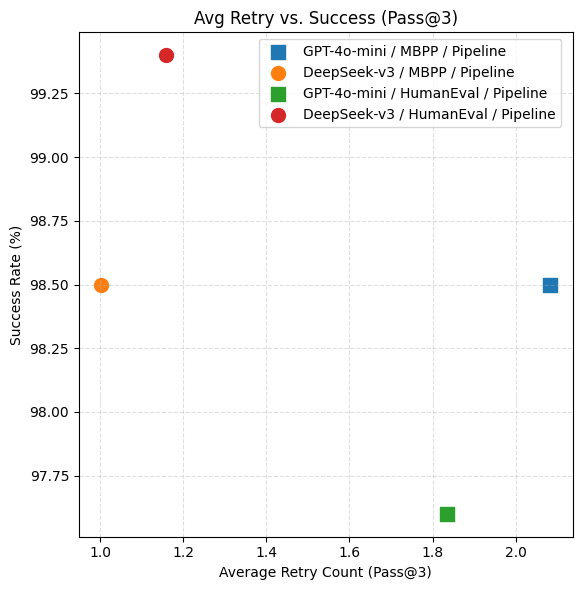

In [19]:
color_map = {
    'GPT-4o-mini': 'blue',
    'DeepSeek-v3': 'orange'
}
marker_map = {
    'GPT-4o-mini': 's',
    'DeepSeek-v3': 'o'
}

def compute_avg_retry(row):
    total_avg = 0.0
    for k in range(6):
        pct_k = row[f'Retry-{k}'] / 100.0
        succ_frac = row['Success'] / 100.0
        total_avg += k * (pct_k * succ_frac)
    return total_avg

pipeline_pass3['AvgRetry'] = pipeline_pass3.apply(compute_avg_retry, axis=1)

fig, ax = plt.subplots(figsize=(6, 6))
labels_done = set()
for _, r in pipeline_pass3.iterrows():
    llm = r['LLM']
    marker = marker_map.get(llm, 'x')
    ax.scatter(r['AvgRetry'], r['Success'], s=100, marker=marker, label=r['Condition'])

ax.set_xlabel('Average Retry Count (Pass@3)')
ax.set_ylabel('Success Rate (%)')
ax.set_title('Avg Retry vs. Success (Pass@3)')
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc='upper left', bbox_to_anchor=(0.35,1))
plt.tight_layout()
plt.show()

#### Median Retry vs. Success (Pass@3)

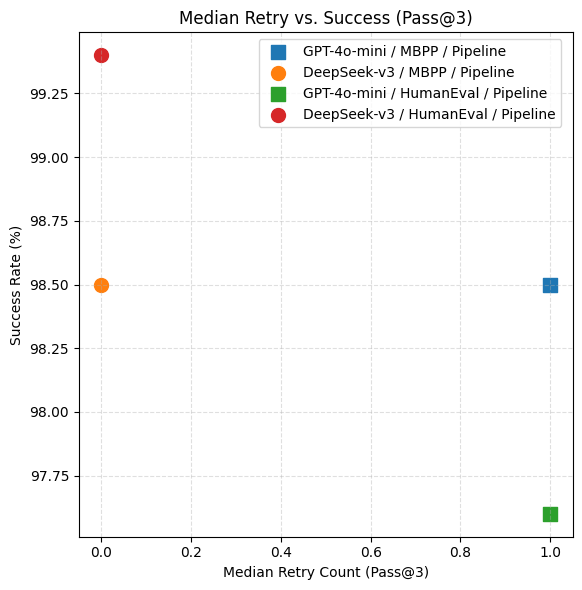

In [20]:
def compute_median_retry(row):
    retries = [row[f"Retry-{k}"] for k in range(6)]
    # total = sum(retries)
    cum_sum = 0.0
    for k, pct in enumerate(retries):
        cum_sum += pct
        if cum_sum >= 50:
            return k
    return 5

pipeline_pass3['MedianRetry'] = pipeline_pass3.apply(compute_median_retry, axis=1)
fig, ax = plt.subplots(figsize=(6, 6))
labels_done = set()

for _, r in pipeline_pass3.iterrows():
    llm = r['LLM']
    marker = marker_map.get(llm, 'x')
    ax.scatter(r['MedianRetry'], r['Success'], s=100, marker=marker, label=r['Condition'])

ax.set_xlabel('Median Retry Count (Pass@3)')
ax.set_ylabel('Success Rate (%)')
ax.set_title('Median Retry vs. Success (Pass@3)')
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc='upper left', bbox_to_anchor=(0.35,1))
plt.tight_layout()
plt.show()